<a href="https://colab.research.google.com/github/Kaykayag/hgraph2graph/blob/master/Part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import os

# Only mount Drive if we are actually in Colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    # Path to your drive folder
    os.chdir('/content/drive/MyDrive/FreeAi')
else:

    print("Running locally.")

Mounted at /content/drive


In [4]:
!git clone https://github.com/Kaykayag/hgraph2graph.git

Cloning into 'hgraph2graph'...
remote: Enumerating objects: 318, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 318 (delta 98), reused 77 (delta 77), pack-reused 181 (from 1)
Receiving objects: 100% (318/318), 151.42 MiB | 14.30 MiB/s, done.
Resolving deltas: 100% (186/186), done.
Updating files: 100% (90/90), done.


In [5]:
%cd hgraph2graph

/content/drive/MyDrive/FreeAi/hgraph2graph


In [6]:
!pip install torch rdkit networkx numpy pandas matplotlib tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 66.0 MB/s eta 0:00:00


In [8]:
import torch
import torch. nn as nn
from torch.utils.data import DataLoader
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit import DataStructs

# Suppress RDKit warnings
lg = rdkit.RDLogger.logger()
lg.setLevel(rdkit.RDLogger.CRITICAL)

# Import hgraph modules
import sys
#sys.path.insert(0, '/content/hgraph2graph')
from hgraph import HierVAE, MolGraph, common_atom_vocab, Vocab, PairVocab
from hgraph import MoleculeDataset

# Set random seeds for reproducibility
SEED = 67
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("✅ All imports successful!")

✅ All imports successful!


In [9]:
# Define model arguments as a namespace object
class Args:
    def __init__(self):
        self.vocab = None  # Will be set below
        self.atom_vocab = common_atom_vocab
        self.rnn_type = 'LSTM'
        self.hidden_size = 250
        self.embed_size = 250
        self.batch_size = 20
        self.latent_size = 32
        self.depthT = 15
        self.depthG = 15
        self.diterT = 1
        self.diterG = 3
        self.dropout = 0.0

args = Args()

# Load vocabulary
vocab_path = 'data/chembl/vocab.txt'
vocab = [x.strip("\r\n ").split() for x in open(vocab_path)]
args.vocab = PairVocab(vocab)

print(f"Vocabulary size: {len(vocab)} motif pairs")

# Load pretrained model
model_path = 'ckpt/chembl-pretrained/model.ckpt'
model = HierVAE(args).to(device)

# Load checkpoint (the checkpoint is saved as a tuple:  (state_dict, optimizer_state))
checkpoint = torch.load(model_path, map_location=device)
if isinstance(checkpoint, tuple):
    model.load_state_dict(checkpoint[0])
else:
    model.load_state_dict(checkpoint)

model.eval()
print("✅ Model loaded successfully!")

Vocabulary size: 5623 motif pairs


/usr/local/lib/python3.12/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


✅ Model loaded successfully!


In [10]:
#Define Test Molecules (Diverse Set)
# Diverse set of molecules for testing (varying size and complexity)
# Including simple, medium, and complex molecules
TEST_SMILES = [
    # Simple molecules
    "CCO",                                      # Ethanol
    "CC(=O)O",                                  # Acetic acid
    "c1ccccc1",                                 # Benzene
    "CC(C)O",                                   # Isopropanol
    "CCN",                                      # Ethylamine

    # Medium complexity
    "CC(=O)Oc1ccccc1C(=O)O",                   # Aspirin
    "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",            # Caffeine
    "CC(C)Cc1ccc(C(C)C(=O)O)cc1",              # Ibuprofen
    "c1ccc2c(c1)ccc1ccccc12",                  # Phenanthrene
    "Oc1ccc(O)cc1",                            # Hydroquinone

    # More complex drug-like molecules
    "COc1ccc2nc(S(=O)Cc3ncc(C)c(OC)c3C)[nH]c2c1",  # Omeprazole
    "CC(C)Cc1ccc(cc1)C(C)C(=O)O",              # Ibuprofen variant
    "c1ccc(cc1)C2=NCC(=O)Nc3ccccc23",          # Benzodiazepine core
    "Cn1cnc2c1c(=O)n(c(=O)n2C)C",              # Theophylline
    "OC(=O)c1ccccc1O",                         # Salicylic acid

    # Ring systems
    "C1CCCCC1",                                 # Cyclohexane
    "c1ccc2ccccc2c1",                          # Naphthalene
    "C1CCC2CCCCC2C1",                          # Decalin
    "c1ccc2[nH]ccc2c1",                        # Indole
    "c1cnc2ccccc2n1",                          # Quinazoline

    # Heteroatom-containing
    "c1ccncc1",                                # Pyridine
    "c1ccc(N)cc1",                             # Aniline
    "CC(=O)Nc1ccc(O)cc1",                      # Paracetamol
    "Nc1ccc(N)cc1",                            # p-Phenylenediamine
    "c1ccc(Cl)cc1",                            # Chlorobenzene

    # Additional diverse molecules
    "CCCCCCCC",                                # Octane
    "CC(C)(C)c1ccc(O)cc1",                     # 4-tert-Butylphenol
    "O=C1CCCCC1",                              # Cyclohexanone
    "CCc1ccccc1",                              # Ethylbenzene
    "COc1ccccc1",                              # Anisole
]

# Validate all SMILES
valid_smiles = []
for smi in TEST_SMILES:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        # Canonicalize
        can_smi = Chem.MolToSmiles(mol)
        valid_smiles.append(can_smi)
    else:
        print(f"Invalid SMILES: {smi}")

print(f"✅ {len(valid_smiles)} valid test molecules prepared")

✅ 30 valid test molecules prepared


In [11]:
#  Reconstruction Function

def reconstruct_molecules(model, smiles_list, vocab, atom_vocab, batch_size=20):
    """
    Reconstruct molecules using the HierVAE model.
    Returns list of (input_smiles, output_smiles) tuples.
    """
    results = []

    # Filter molecules that are compatible with the vocabulary
    compatible_smiles = []
    for smi in smiles_list:
        try:
            hmol = MolGraph(smi)
            ok = True
            for node, attr in hmol.mol_tree.nodes(data=True):
                smiles_node = attr['smiles']
                ok &= attr['label'] in vocab.vmap
                for i, s in attr['inter_label']:
                    ok &= (smiles_node, s) in vocab.vmap
            if ok:
                compatible_smiles.append(smi)
            else:
                # Molecule not in vocabulary - mark as failed
                results.append((smi, None, "Not in vocabulary"))
        except Exception as e:
            results.append((smi, None, f"Error:  {str(e)}"))

    if len(compatible_smiles) == 0:
        print("No compatible molecules found!")
        return results

    print(f"Compatible molecules:  {len(compatible_smiles)}/{len(smiles_list)}")

    # Create dataset and dataloader
    dataset = MoleculeDataset(compatible_smiles, vocab, atom_vocab, batch_size)
    loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0,
                       collate_fn=lambda x: x[0])

    # Reconstruct
    with torch.no_grad():
        batch_idx = 0
        for batch in tqdm(loader, desc="Reconstructing"):
            start_idx = batch_size * batch_idx
            end_idx = min(batch_size * (batch_idx + 1), len(compatible_smiles))
            orig_smiles_batch = compatible_smiles[start_idx: end_idx]

            try:
                dec_smiles = model.reconstruct(batch)
                for orig, dec in zip(orig_smiles_batch, dec_smiles):
                    results.append((orig, dec, "Success"))
            except Exception as e:
                for orig in orig_smiles_batch:
                    results.append((orig, None, f"Decode error: {str(e)}"))

            batch_idx += 1

    return results

print("✅ Reconstruction function defined")

✅ Reconstruction function defined


In [12]:
# Metric Calculation Functions

def calculate_tanimoto(smiles1, smiles2, radius=2, nBits=2048):
    """Calculate Tanimoto similarity using Morgan fingerprints."""
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    if mol1 is None or mol2 is None:
        return None

    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, radius, nBits=nBits)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, radius, nBits=nBits)

    return DataStructs.TanimotoSimilarity(fp1, fp2)

def get_mol_properties(smiles):
    """Get molecular properties for a SMILES string."""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    return {
        'num_atoms': mol. GetNumAtoms(),
        'num_bonds': mol.GetNumBonds(),
        'num_rings':  Chem.GetSSSR(mol).__len__(),
        'num_aromatic_atoms': sum(1 for atom in mol.GetAtoms() if atom.GetIsAromatic()),
        'num_heteroatoms': sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() not in [1, 6]),
        'molecular_weight': Descriptors.MolWt(mol),
    }

def calculate_error_diagnostics(smiles_in, smiles_out):
    """Calculate detailed error diagnostics between input and output molecules."""
    mol_in = Chem.MolFromSmiles(smiles_in)
    mol_out = Chem.MolFromSmiles(smiles_out)

    if mol_in is None or mol_out is None:
        return None

    props_in = get_mol_properties(smiles_in)
    props_out = get_mol_properties(smiles_out)

    return {
        'delta_atoms': props_out['num_atoms'] - props_in['num_atoms'],
        'delta_bonds': props_out['num_bonds'] - props_in['num_bonds'],
        'delta_rings': props_out['num_rings'] - props_in['num_rings'],
        'delta_aromatic_atoms': props_out['num_aromatic_atoms'] - props_in['num_aromatic_atoms'],
        'delta_heteroatoms':  props_out['num_heteroatoms'] - props_in['num_heteroatoms'],
        'delta_mw': props_out['molecular_weight'] - props_in['molecular_weight'],
    }

def is_exact_match(smiles1, smiles2):
    """Check if two SMILES represent the same molecule (canonical comparison)."""
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    if mol1 is None or mol2 is None:
        return False

    can1 = Chem.MolToSmiles(mol1)
    can2 = Chem. MolToSmiles(mol2)

    return can1 == can2

def is_valid_molecule(smiles):
    """Check if SMILES represents a valid molecule."""
    if smiles is None or smiles == "":
        return False
    mol = Chem. MolFromSmiles(smiles)
    return mol is not None

print("✅ Metric functions defined")

✅ Metric functions defined


In [13]:
# Reconstruction Experiment

print("Starting reconstruction experiment...")
print("="*50)

# Run reconstruction
reconstruction_results = reconstruct_molecules(
    model,
    valid_smiles,
    args.vocab,
    args.atom_vocab,
    batch_size=args.batch_size
)

print(f"\n✅ Reconstruction complete:  {len(reconstruction_results)} molecules processed")

Starting reconstruction experiment...
Compatible molecules:  26/30
After pruning 26 -> 26


Reconstructing: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


✅ Reconstruction complete:  30 molecules processed


In [14]:
# Calculate All Metrics and Create results. csv
# Build results dataframe
results_data = []

for idx, (smiles_in, smiles_out, status) in enumerate(reconstruction_results):
    row = {
        'id': idx,
        'smiles_in': smiles_in,
        'smiles_out': smiles_out if smiles_out else "",
        'valid_out': 1 if is_valid_molecule(smiles_out) else 0,
        'exact_match': 1 if (smiles_out and is_exact_match(smiles_in, smiles_out)) else 0,
        'tanimoto':  None,
        'delta_atoms': None,
        'delta_bonds': None,
        'delta_rings': None,
        'delta_aromatic_atoms': None,
        'delta_heteroatoms':  None,
        'delta_mw':  None,
        'status': status
    }

    # Calculate Tanimoto if output is valid
    if is_valid_molecule(smiles_out):
        row['tanimoto'] = calculate_tanimoto(smiles_in, smiles_out)

        # Calculate error diagnostics
        diagnostics = calculate_error_diagnostics(smiles_in, smiles_out)
        if diagnostics:
            row['delta_atoms'] = diagnostics['delta_atoms']
            row['delta_bonds'] = diagnostics['delta_bonds']
            row['delta_rings'] = diagnostics['delta_rings']
            row['delta_aromatic_atoms'] = diagnostics['delta_aromatic_atoms']
            row['delta_heteroatoms'] = diagnostics['delta_heteroatoms']
            row['delta_mw'] = diagnostics['delta_mw']

    results_data.append(row)

# Create DataFrame
df = pd. DataFrame(results_data)

# Save to CSV (required format)
df_csv = df[['id', 'smiles_in', 'smiles_out', 'valid_out', 'exact_match',
             'tanimoto', 'delta_atoms', 'delta_bonds']].copy()
df_csv. to_csv('results.csv', index=False)
print("✅ results.csv saved!")

# Display first few rows
print("\nFirst 10 rows of results:")
display(df. head(10))

✅ results.csv saved!

First 10 rows of results:


,id,smiles_in,smiles_out,valid_out,exact_match,tanimoto,delta_atoms,delta_bonds,delta_rings,delta_aromatic_atoms,delta_heteroatoms,delta_mw,status
0,0,Cn1c(=O)c2c(ncn2C)n(C)c1=O,,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not in vocabulary
1,1,COc1ccc2nc(S(=O)Cc3ncc(C)c(OC)c3C)[nH]c2c1,,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not in vocabulary
2,2,Cn1c(=O)c2c(ncn2C)n(C)c1=O,,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not in vocabulary
3,3,c1ccc2[nH]ccc2c1,,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not in vocabulary
4,4,CCO,CCOC(=O)c1ccccc1,1,0,0.166667,8.0,9.0,1.0,6.0,1.0,104.108,Success
5,5,CC(=O)O,CC(=O)Oc1ccc(Cl)cc1,1,0,0.217391,7.0,8.0,1.0,6.0,1.0,110.543,Success
6,6,c1ccccc1,c1ccc(C2=NCCO2)cc1,1,0,0.136364,5.0,6.0,1.0,0.0,2.0,69.063,Success
7,7,CC(C)O,CC(C)(O)c1ccccc1,1,0,0.100000,6.0,7.0,1.0,6.0,0.0,76.098,Success
8,8,CCN,CCN(CC)c1ccccc1,1,0,0.150000,8.0,9.0,1.0,6.0,0.0,104.152,Success
9,9,CC(=O)Oc1ccccc1C(=O)O,CC(=O)Oc1ccccc1C(=O)O,1,1,1.000000,0.0,0.0,0.0,0.0,0.0,0.000,Success


In [15]:
# Summary Metrics Table


# Calculate summary statistics
total_molecules = len(df)
valid_outputs = df['valid_out']. sum()
exact_matches = df['exact_match'].sum()

# Filter for valid outputs for Tanimoto stats
valid_df = df[df['valid_out'] == 1]

print("="*60)
print("PART A: RECONSTRUCTION METRICS SUMMARY TABLE")
print("="*60)

summary_table = pd.DataFrame({
    'Metric': [
        'Total Molecules Tested',
        'Valid Reconstructions',
        'Validity Rate (%)',
        'Exact Matches',
        'Exact Match Accuracy (%)',
        'Mean Tanimoto Similarity',
        'Median Tanimoto Similarity',
        'Min Tanimoto Similarity',
        'Max Tanimoto Similarity',
        'Std Tanimoto Similarity',
    ],
    'Value': [
        total_molecules,
        valid_outputs,
        f"{100 * valid_outputs / total_molecules:.2f}" if total_molecules > 0 else "N/A",
        exact_matches,
        f"{100 * exact_matches / total_molecules:.2f}" if total_molecules > 0 else "N/A",
        f"{valid_df['tanimoto'].mean():.4f}" if len(valid_df) > 0 else "N/A",
        f"{valid_df['tanimoto'].median():.4f}" if len(valid_df) > 0 else "N/A",
        f"{valid_df['tanimoto'].min():.4f}" if len(valid_df) > 0 else "N/A",
        f"{valid_df['tanimoto'].max():.4f}" if len(valid_df) > 0 else "N/A",
        f"{valid_df['tanimoto'].std():.4f}" if len(valid_df) > 0 else "N/A",
    ]
})

print(summary_table.to_string(index=False))
print()

# Error diagnostics summary
if len(valid_df) > 0:
    print("\n" + "="*60)
    print("ERROR DIAGNOSTICS SUMMARY (for valid reconstructions)")
    print("="*60)

    error_summary = pd.DataFrame({
        'Diagnostic': ['Delta Atoms', 'Delta Bonds', 'Delta Rings',
                      'Delta Aromatic Atoms', 'Delta Heteroatoms', 'Delta MW'],
        'Mean': [
            f"{valid_df['delta_atoms'].mean():.2f}",
            f"{valid_df['delta_bonds'].mean():.2f}",
            f"{valid_df['delta_rings'].mean():.2f}",
            f"{valid_df['delta_aromatic_atoms'].mean():.2f}",
            f"{valid_df['delta_heteroatoms'].mean():.2f}",
            f"{valid_df['delta_mw'].mean():.2f}",
        ],
        'Std': [
            f"{valid_df['delta_atoms'].std():.2f}",
            f"{valid_df['delta_bonds'].std():.2f}",
            f"{valid_df['delta_rings'].std():.2f}",
            f"{valid_df['delta_aromatic_atoms'].std():.2f}",
            f"{valid_df['delta_heteroatoms'].std():.2f}",
            f"{valid_df['delta_mw'].std():.2f}",
        ],
        'Min': [
            valid_df['delta_atoms'].min(),
            valid_df['delta_bonds'].min(),
            valid_df['delta_rings'].min(),
            valid_df['delta_aromatic_atoms'].min(),
            valid_df['delta_heteroatoms'].min(),
            f"{valid_df['delta_mw']. min():.1f}",
        ],
        'Max': [
            valid_df['delta_atoms'].max(),
            valid_df['delta_bonds'].max(),
            valid_df['delta_rings'].max(),
            valid_df['delta_aromatic_atoms'].max(),
            valid_df['delta_heteroatoms'].max(),
            f"{valid_df['delta_mw'].max():.1f}",
        ]
    })

    print(error_summary.to_string(index=False))

PART A: RECONSTRUCTION METRICS SUMMARY TABLE
                    Metric  Value
    Total Molecules Tested     30
     Valid Reconstructions     26
         Validity Rate (%)  86.67
             Exact Matches      7
  Exact Match Accuracy (%)  23.33
  Mean Tanimoto Similarity 0.4594
Median Tanimoto Similarity 0.4000
   Min Tanimoto Similarity 0.0333
   Max Tanimoto Similarity 1.0000
   Std Tanimoto Similarity 0.3592


ERROR DIAGNOSTICS SUMMARY (for valid reconstructions)
          Diagnostic  Mean   Std  Min   Max
         Delta Atoms  4.50  3.75  0.0  12.0
         Delta Bonds  5.23  4.39  0.0  14.0
         Delta Rings  0.73  0.67  0.0   2.0
Delta Aromatic Atoms  3.42  4.21 -1.0  16.0
   Delta Heteroatoms  0.85  1.01  0.0   4.0
            Delta MW 60.54 49.04  0.0 154.2


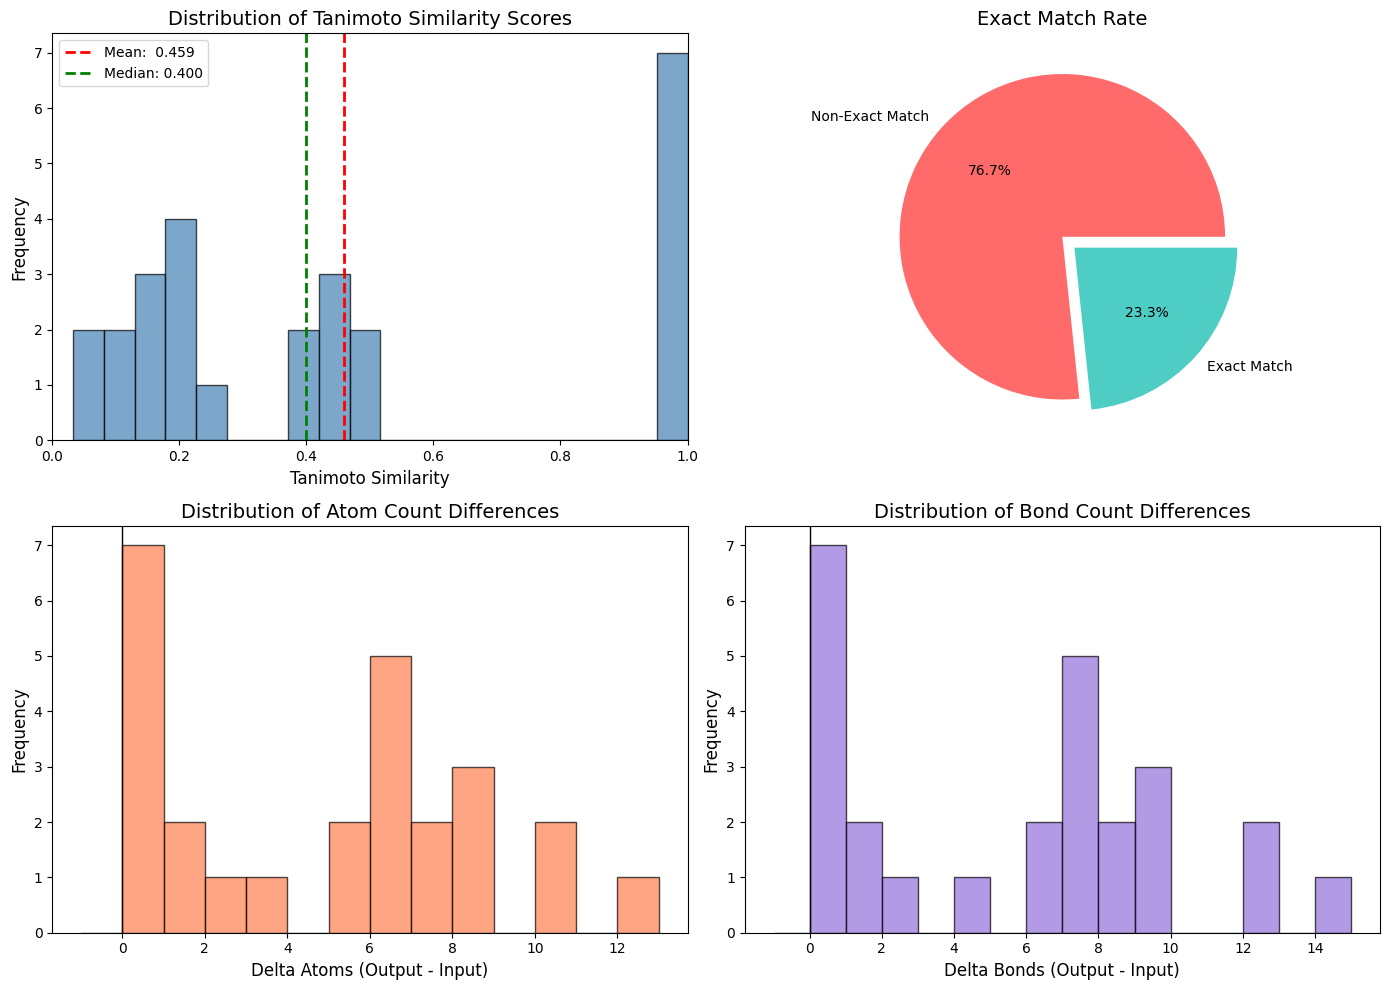

✅ Plots saved to reconstruction_metrics.png


In [16]:
# Visualization - Similarity Distribution

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Tanimoto Similarity Distribution (Histogram)
ax1 = axes[0, 0]
if len(valid_df) > 0:
    ax1.hist(valid_df['tanimoto']. dropna(), bins=20, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.axvline(valid_df['tanimoto'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean:  {valid_df["tanimoto"].mean():.3f}')
    ax1.axvline(valid_df['tanimoto'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {valid_df["tanimoto"].median():.3f}')
    ax1.legend()
ax1.set_xlabel('Tanimoto Similarity', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of Tanimoto Similarity Scores', fontsize=14)
ax1.set_xlim(0, 1)

# 2. Exact Match vs Non-Exact Match
ax2 = axes[0, 1]
match_counts = df['exact_match']. value_counts()
colors = ['#ff6b6b', '#4ecdc4']
labels = ['Non-Exact Match', 'Exact Match']
sizes = [match_counts. get(0, 0), match_counts.get(1, 0)]
ax2.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=(0, 0.1))
ax2.set_title('Exact Match Rate', fontsize=14)

# 3. Delta Atoms Distribution
ax3 = axes[1, 0]
if len(valid_df) > 0 and 'delta_atoms' in valid_df.columns:
    delta_atoms = valid_df['delta_atoms'].dropna()
    ax3.hist(delta_atoms, bins=range(int(delta_atoms. min())-1, int(delta_atoms.max())+2),
             edgecolor='black', alpha=0.7, color='coral')
ax3.set_xlabel('Delta Atoms (Output - Input)', fontsize=12)
ax3.set_ylabel('Frequency', fontsize=12)
ax3.set_title('Distribution of Atom Count Differences', fontsize=14)
ax3.axvline(0, color='black', linestyle='-', linewidth=1)

# 4. Delta Bonds Distribution
ax4 = axes[1, 1]
if len(valid_df) > 0 and 'delta_bonds' in valid_df.columns:
    delta_bonds = valid_df['delta_bonds']. dropna()
    ax4.hist(delta_bonds, bins=range(int(delta_bonds.min())-1, int(delta_bonds. max())+2),
             edgecolor='black', alpha=0.7, color='mediumpurple')
ax4.set_xlabel('Delta Bonds (Output - Input)', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Distribution of Bond Count Differences', fontsize=14)
ax4.axvline(0, color='black', linestyle='-', linewidth=1)

plt.tight_layout()
plt.savefig('reconstruction_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Plots saved to reconstruction_metrics.png")

10 QUALITATIVE EXAMPLES:  Input vs Reconstruction


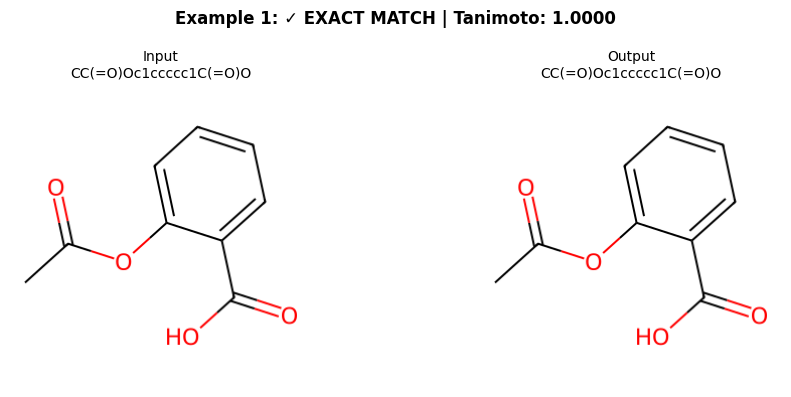

Example 1:  Perfect reconstruction - the model exactly reproduces CC(=O)Oc1ccccc1C(=O)O.



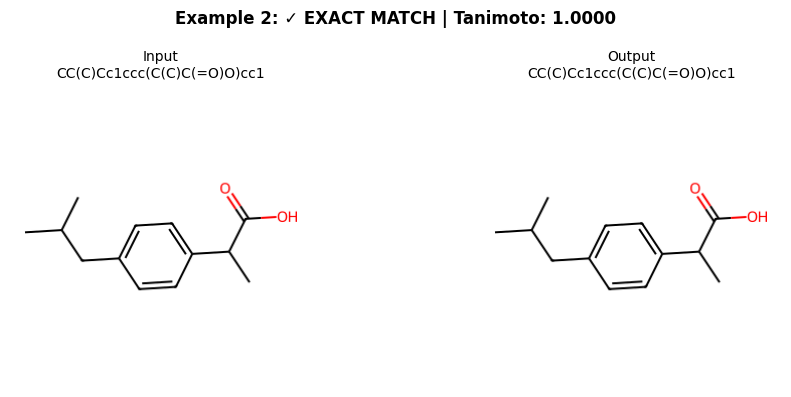

Example 2:  Perfect reconstruction - the model exactly reproduces CC(C)Cc1ccc(C(C)C(=O)O)cc1.



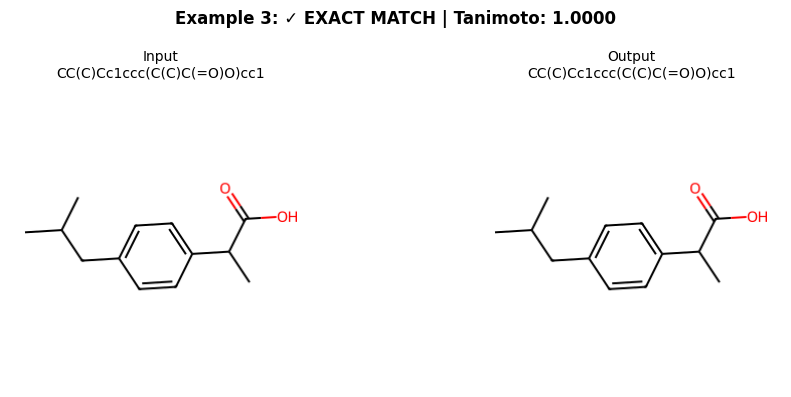

Example 3:  Perfect reconstruction - the model exactly reproduces CC(C)Cc1ccc(C(C)C(=O)O)cc1.



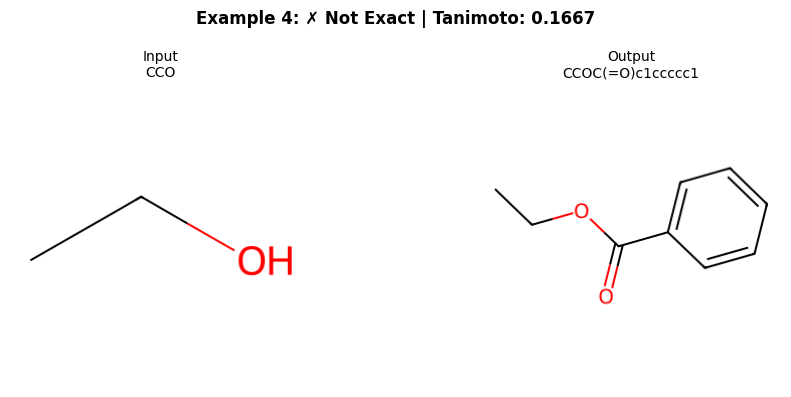

Example 4:  Significant reconstruction error (Tanimoto=0.167). Major changes: Δatoms=8.0, Δbonds=9.0.



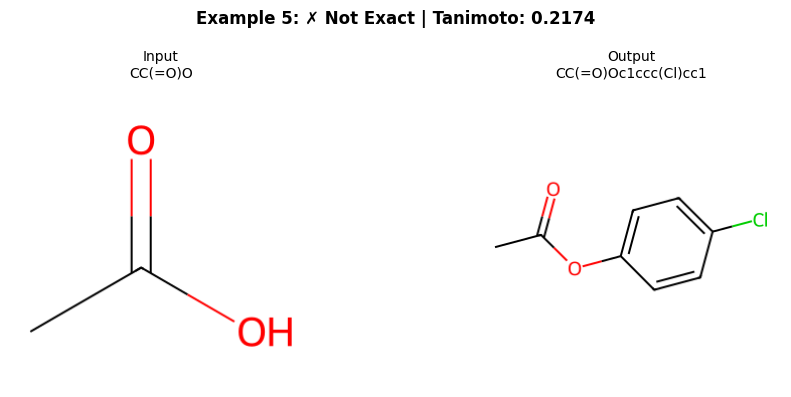

Example 5:  Significant reconstruction error (Tanimoto=0.217). Major changes: Δatoms=7.0, Δbonds=8.0.



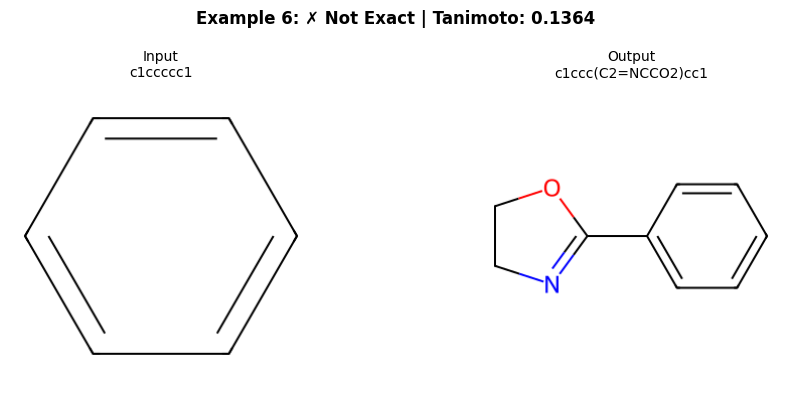

Example 6:  Significant reconstruction error (Tanimoto=0.136). Major changes: Δatoms=5.0, Δbonds=6.0.



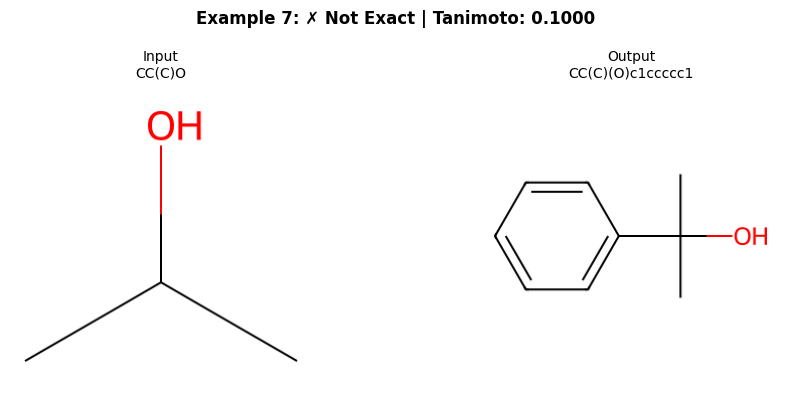

Example 7:  Significant reconstruction error (Tanimoto=0.100). Major changes: Δatoms=6.0, Δbonds=7.0.



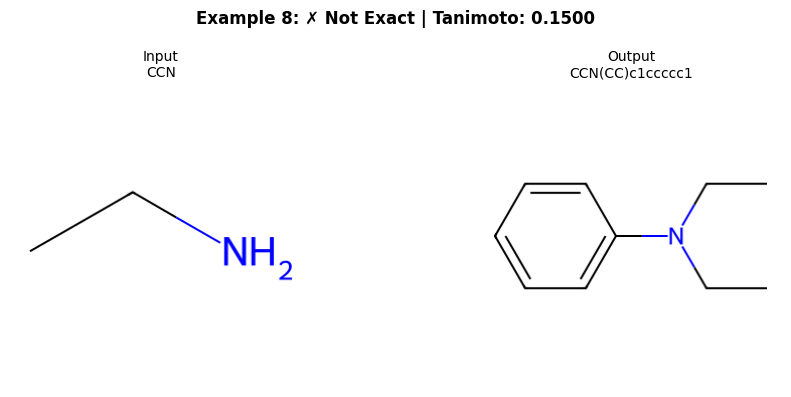

Example 8:  Significant reconstruction error (Tanimoto=0.150). Major changes: Δatoms=8.0, Δbonds=9.0.



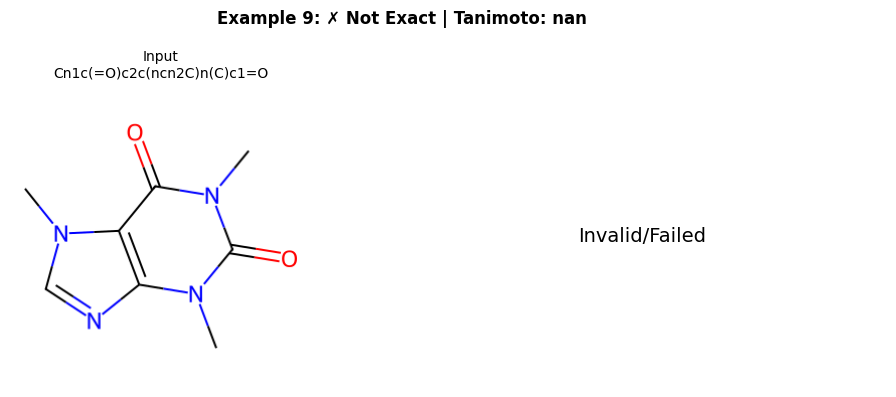

Example 9:  Reconstruction failed - the model could not generate a valid molecule from Cn1c(=O)c2c(ncn2C)n(C)c1=O.



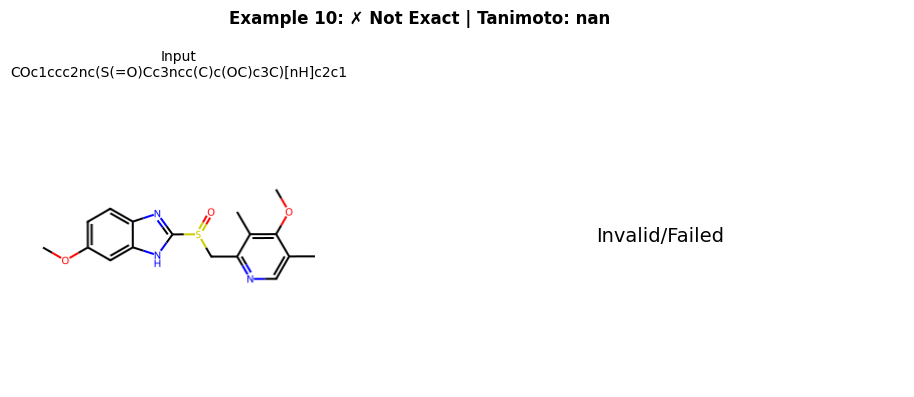

Example 10:  Reconstruction failed - the model could not generate a valid molecule from COc1ccc2nc(S(=O)Cc3ncc(C)c(OC)c3C)[nH]c2c1.



In [17]:
# Qualitative Examples with Visualizations

def draw_molecule_comparison(smiles_in, smiles_out, idx, tanimoto, exact_match):
    """Draw input and output molecules side by side."""
    mol_in = Chem.MolFromSmiles(smiles_in)
    mol_out = Chem.MolFromSmiles(smiles_out) if smiles_out else None

    fig, axes = plt. subplots(1, 2, figsize=(10, 4))

    # Input molecule
    if mol_in:
        img_in = Draw.MolToImage(mol_in, size=(300, 300))
        axes[0]. imshow(img_in)
        axes[0].set_title(f'Input\n{smiles_in}', fontsize=10)
    axes[0].axis('off')

    # Output molecule
    if mol_out:
        img_out = Draw.MolToImage(mol_out, size=(300, 300))
        axes[1].imshow(img_out)
        axes[1].set_title(f'Output\n{smiles_out}', fontsize=10)
    else:
        axes[1].text(0.5, 0.5, 'Invalid/Failed', ha='center', va='center', fontsize=14)
    axes[1].axis('off')

    # Add metrics
    match_str = "✓ EXACT MATCH" if exact_match else "✗ Not Exact"
    tanimoto_str = f"Tanimoto: {tanimoto:.4f}" if tanimoto else "Tanimoto: N/A"
    fig.suptitle(f'Example {idx+1}: {match_str} | {tanimoto_str}', fontsize=12, fontweight='bold')

    plt. tight_layout()
    return fig

# Select 10 diverse examples (mix of matches and non-matches)
print("="*60)
print("10 QUALITATIVE EXAMPLES:  Input vs Reconstruction")
print("="*60)

# Get a mix of examples
examples = []

# Try to get exact matches
exact_matches_df = df[df['exact_match'] == 1]. head(3)
for _, row in exact_matches_df.iterrows():
    examples.append(row)

# Get non-exact but valid
non_exact_valid = df[(df['exact_match'] == 0) & (df['valid_out'] == 1)].head(5)
for _, row in non_exact_valid.iterrows():
    examples.append(row)

# Get invalid outputs if any
invalid_outputs = df[df['valid_out'] == 0].head(2)
for _, row in invalid_outputs. iterrows():
    examples.append(row)

# Fill to 10 if needed
remaining = 10 - len(examples)
if remaining > 0:
    for _, row in df.head(remaining).iterrows():
        if row['id'] not in [e['id'] for e in examples]:
            examples.append(row)

# Limit to 10
examples = examples[:10]

# Generate interpretations
interpretations = []
for i, row in enumerate(examples):
    smiles_in = row['smiles_in']
    smiles_out = row['smiles_out']
    exact = row['exact_match']
    tanimoto = row['tanimoto']

    # Draw comparison
    fig = draw_molecule_comparison(smiles_in, smiles_out, i, tanimoto, exact)
    plt.savefig(f'example_{i+1}.png', dpi=100, bbox_inches='tight')
    plt.show()

    # Generate interpretation
    if exact:
        interp = f"Example {i+1}:  Perfect reconstruction - the model exactly reproduces {smiles_in}."
    elif row['valid_out'] == 0:
        interp = f"Example {i+1}:  Reconstruction failed - the model could not generate a valid molecule from {smiles_in}."
    else:
        delta_atoms = row. get('delta_atoms', 0)
        delta_bonds = row.get('delta_bonds', 0)
        if tanimoto and tanimoto > 0.9:
            interp = f"Example {i+1}: Near-perfect reconstruction (Tanimoto={tanimoto:.3f}). Minor differences:  Δatoms={delta_atoms}, Δbonds={delta_bonds}."
        elif tanimoto and tanimoto > 0.7:
            interp = f"Example {i+1}: Good reconstruction (Tanimoto={tanimoto:.3f}). Notable changes: Δatoms={delta_atoms}, Δbonds={delta_bonds}."
        else:
            interp = f"Example {i+1}:  Significant reconstruction error (Tanimoto={tanimoto:.3f}). Major changes: Δatoms={delta_atoms}, Δbonds={delta_bonds}."

    print(interp)
    print()

In [18]:
# CELL 12: Download Results

# Create a summary for the report
print("="*60)
print("FILES CREATED:")
print("="*60)
print("1. results.csv - Main results file with required columns")
print("2. reconstruction_metrics.png - Summary plots")
print("3. example_1.png through example_10.png - Qualitative examples")

# Download results. csv (for Google Colab)
from google.colab import files
files.download('results.csv')
files.download('reconstruction_metrics.png')

print("\n✅ All Part A deliverables complete!")

FILES CREATED:
1. results.csv - Main results file with required columns
2. reconstruction_metrics.png - Summary plots
3. example_1.png through example_10.png - Qualitative examples


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ All Part A deliverables complete!
